# Extract features from textual data using BERT and Path signature

In [1]:
import pandas as pd
import torch
import pickle
import re

import nlpsig
from nlpsig.ffn import FeedforwardNeuralNetModel
from nlpsig.focal_loss import FocalLoss
from nlpsig.huggingface_loader import loadHF

/Users/rchan/opt/miniconda3/envs/py38esig/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In this notebook, we use the `newspop` dataset from Huggingface and add timeline IDs and post IDs to each item. The `loadHF` class is to process this dataset.

In [2]:
# loadHF: load a dataset from hugging face
data_loader = loadHF(dataset_name="newspop", split_name="train")
data_loader.load_preprocessed_df(default_preprocess="newspop")
dataset_df = data_loader.dataset_df

[INFO] load dataframe, split: train...


Found cached dataset newspop (/Users/rchan/.cache/huggingface/datasets/newspop/default/0.0.0/9904d4082ffd3c0953efa538ff926c43d27da8f37c9b5d6a13f51ab96740474e)
100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 278.25it/s]


[INFO] preprocess...
[INFO] preprocessed dataframe can be accessed: .dataset_df


In [3]:
dataset_df.head()

,content,datetime,label,timeline_id,postid
0,Obama Lays Wreath at Arlington National Cemete...,2015-01-06 00:00:00,1,10,3
1,"Tim Haywood, investment director business-unit...",2015-01-06 00:12:00,2,11,3
2,"Nouriel Roubini, NYU professor and chairman at...",2015-01-01 00:12:00,2,1,7
3,Finland's economy expanded marginally in the t...,2015-01-01 00:00:00,2,0,3
4,Tourism and public spending continued to boost...,2015-01-05 00:12:00,2,9,7


In [4]:
len(dataset_df)

93239

We use a smaller subset of the data here.

In [5]:
dataset_df = dataset_df[:2000]
dataset_df["label"].value_counts()

0    1131
2     845
1      24
Name: label, dtype: int64

## Model specifics

Nested dictionary for models specifications.

This includes models for encoding text, path signature and etc.

In [6]:
model_specifics = {
    "encoder_args": {
        "col_name_text": "content",
        "model_name": "all-MiniLM-L6-v2",
        "model_args": {
            "batch_size": 64,
            "show_progress_bar": True,
            "output_value": 'sentence_embedding', 
            "convert_to_numpy": True,
            "convert_to_tensor": False,
            "device": None,
            "normalize_embeddings": False
        }
    },
    "dim_reduction": {
        "method": 'umap', #options: ppapca, ppapcappa, umap
        "num_components": 10, # options: any int number between 1 and embedding dimensions
    },
    "embedding":{
        "global_embedding_tp": 'SBERT', #options: SBERT, BERT_cls , BERT_mean, BERT_max
        "post_embedding_tp": 'sentence', #options: sentence, reduced
        "feature_combination_method": 'attention', #options concatenation, attention 
    },
    "time_injection": {
        "history_tp": 'timestamp', #options: timestamp, None
        "post_tp": 'timestamp', #options: timestamp, timediff, None
    },
    "signature": {
        "dimensions": 3, #options: any int number larger than 1
        "method": 'log', # options: log, sig
        "interval": 1/12
    }
}

## Encode text: obtaining sentence embeddings

We can use the `TextEncoder` class within `nlpsig` to obtain sentence embeddings from a model. Here, we have defined the encoder arguments in `model_specifics`.

In [7]:
model_specifics["encoder_args"]

{'col_name_text': 'content',
 'model_name': 'all-MiniLM-L6-v2',
 'model_args': {'batch_size': 64,
  'show_progress_bar': True,
  'output_value': 'sentence_embedding',
  'convert_to_numpy': True,
  'convert_to_tensor': False,
  'device': None,
  'normalize_embeddings': False}}

We can pass these into the constructor of the class to initialise our text encoder as follows:

In [8]:
# initialise the Text Encoder 
text_encoder = nlpsig.TextEncoder(dataset_df,
                                  col_name_text = model_specifics["encoder_args"]["col_name_text"], 
                                  model_name = model_specifics["encoder_args"]["model_name"],
                                  model_args = model_specifics["encoder_args"]["model_args"])

We can see that these are stored as attributes in the object:

In [9]:
text_encoder.df

,content,datetime,label,timeline_id,postid
0,Obama Lays Wreath at Arlington National Cemete...,2015-01-06 00:00:00,1,10,3
1,"Tim Haywood, investment director business-unit...",2015-01-06 00:12:00,2,11,3
2,"Nouriel Roubini, NYU professor and chairman at...",2015-01-01 00:12:00,2,1,7
3,Finland's economy expanded marginally in the t...,2015-01-01 00:00:00,2,0,3
4,Tourism and public spending continued to boost...,2015-01-05 00:12:00,2,9,7
...,...,...,...,...,...
1995,"Over time, resilient rural producers help form...",2015-01-04 00:00:00,2,6,9
1996,So Jealous reminds Democratic candidates in 20...,2015-01-01 00:00:00,2,0,9
1997,Driven by surging manufacturing across North A...,2015-01-04 00:12:00,2,7,9
1998,Microsoft has started to roll out the first ma...,2015-01-04 00:00:00,0,6,4


In [10]:
text_encoder.col_name_text

'content'

In [11]:
text_encoder.model_name

'all-MiniLM-L6-v2'

In [12]:
text_encoder.model_args

{'batch_size': 64,
 'show_progress_bar': True,
 'output_value': 'sentence_embedding',
 'convert_to_numpy': True,
 'convert_to_tensor': False,
 'device': None,
 'normalize_embeddings': False}

There are other attributes `embeddings_sentence` and `model` which are `None` type when the class is initialised:

In [13]:
print(text_encoder.embeddings_sentence)
print(text_encoder.model)

None
None


The class has a `.encode_sentence_transformer()` method which first loads in the model (using the `model_name` and `model_args` attributes) and then obtains an embedding for each sentence. These sentence embeddings are then stored in the `embeddings_sentence` attribute of the object.

In [14]:
text_encoder.encode_sentence_transformer()
embeddings_sentence = text_encoder.embeddings_sentence

[INFO] number of sentences to encode: 2000


Batches: 100%|████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.75it/s]


### Obtaining embeddings from a pickle file

Note that we could also optionally pass in any pre-computed sentence embeddings (which are saved with a pickle file) if we wanted to. So in this directory, there is a file named `pre_comp_emb.pkl`, we can load these in by:

In [15]:
text_encoder = nlpsig.TextEncoder(df = dataset_df,
                                  pre_computed_embeddings_file = "pre_comp_emb.pkl")

In [16]:
text_encoder.embeddings_sentence

array([[ 0.04053079,  0.12677227,  0.03034634, ...,  0.01346129,
         0.00509907, -0.02261563],
       [ 0.00132176, -0.0018716 ,  0.04704979, ..., -0.12755243,
        -0.00235985, -0.01032072],
       [-0.00446173, -0.07742908, -0.02367788, ..., -0.12149315,
        -0.02713374, -0.01476178],
       ...,
       [ 0.11392148, -0.08496089,  0.04116976, ..., -0.06292846,
        -0.01069093,  0.05599773],
       [-0.00467583,  0.03044874,  0.0136638 , ...,  0.01504119,
         0.07309043,  0.05808413],
       [ 0.00844448, -0.04087541,  0.0106803 , ..., -0.02920137,
         0.03407754,  0.04248996]], dtype=float32)

As we passed in a pickle file, `model_name`, `model_args`, and `model` are given default values to highlight this:

In [17]:
print("model_name: " + text_encoder.model_name)
print("model_args: " + str(text_encoder.model_args))
print("model: " + text_encoder.model)

model_name: pre-computed
model_args: None
model: pre-computed


## Plotting the embeddings with dimensionality reduction

There is a `PlotEmbedding` class within `nlpsig` which can produce two-dimensional plots of the embeddings by first performing a dimensionality reduction. We will do this here using `UMAP`:

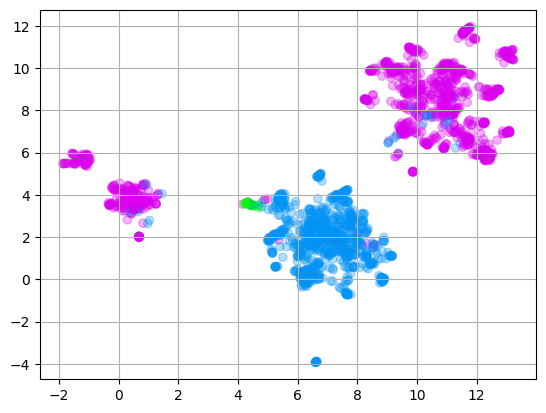

In [18]:
plt_embed = nlpsig.PlotEmbedding(x_data = embeddings_sentence,
                                 y_data = dataset_df["label"].values)

plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 2
    }
)

## Dimensionality reduction

While the `PlotEmbedding` class allows us to visualise the embeddings, the `DimReduce` is more specific to reducing the dimensionality of the embedding space to be used later on (rather than just focus on using it for plotting). We can initialise the object by passing in what method we want to use, choosing out of:

* pca
* umap
* tsne
* ppapca
* ppapcappa

Here we specified our choices in `model_specifics` above:

In [19]:
model_specifics["dim_reduction"]

{'method': 'umap', 'num_components': 10}

The `.fit_transform()` method performs the dimensionality reduction and returns the reduced vectors (they also save them into the `embedding` attribute of the object.

In [20]:
reduction = nlpsig.DimReduce(method = model_specifics["dim_reduction"]['method'], 
                             components = model_specifics["dim_reduction"]['num_components'])
embeddings_reduced = reduction.fit_transform(embeddings_sentence)

In [21]:
print(embeddings_sentence.shape)
print(embeddings_reduced.shape)

(2000, 384)
(2000, 10)


We can again visualise these using the `PlotEmbedding` class.

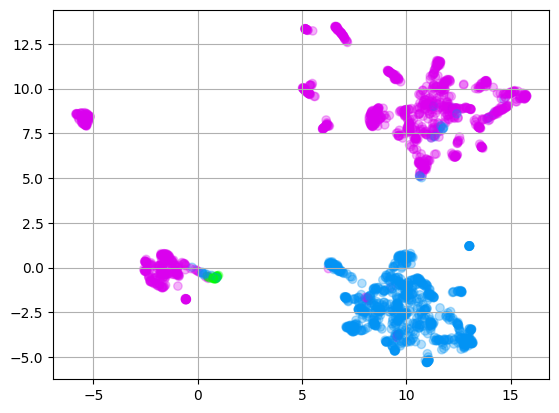

In [22]:
plt_embed = nlpsig.PlotEmbedding(x_data = embeddings_reduced,
                                 y_data = dataset_df["label"].values)

plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 2
    }
)

## Time injection

Ryan: Still need to go over these classes!

In [23]:
# concatenate new dataframe 
df = nlpsig.get_modeling_dataframe(dataset_df,
                                   embeddings_sentence,
                                   embeddings_reduced)

# get time features
tf = nlpsig.TimeFeatures()
df = tf.get_time_features(df)

# padding
pad = nlpsig.Padding()
df_padded = pad.pad_timelines(df)
df_padded.shape

(12, 181, 13)

In [24]:
id_counts = df.groupby(['timeline_id'])['timeline_id'].count()

In [25]:
df[["content", "datetime", "label", "postid"]]

,content,datetime,label,postid
0,Finland's economy expanded marginally in the t...,2015-01-01 00:00:00,2,3
1,What is A + B? Welcome to our review of Word f...,2015-01-01 00:00:00,0,7
2,By George Georgiopoulos ATHENS (Reuters) - Gre...,2015-01-01 00:00:00,2,2
3,China's central bank on Monday cut the proport...,2015-01-01 00:00:00,2,0
4,"On February 2, Microsoft announced the acquisi...",2015-01-01 00:00:00,0,9
...,...,...,...,...
1995,Leaders of the Group of 20 major economies (G2...,2015-01-06 00:12:00,2,1
1996,Get ready for split-screen productivity. Micro...,2015-01-06 00:12:00,0,9
1997,"Microsoft has launched Cortana, the personal d...",2015-01-06 00:12:00,0,6
1998,Windows 10 is actually pretty great. But Micro...,2015-01-06 00:12:00,0,7


In [26]:
if (model_specifics["time_injection"]["history_tp"] == 'timestamp'):
    path = torch.from_numpy(df_padded[: , : , 2:].astype(float))
else:
    path = torch.from_numpy(df_padded[: , : , 3:].astype(float))

if (model_specifics["time_injection"]["post_tp"]== 'timestamp'):
    time_feature = torch.tensor((df[['time_encoding']].values - df['time_encoding'].mean()) / df['time_encoding'].std() )
    post_time = True
elif (model_specifics["time_injection"]["post_tp"]== 'timediff'):
    time_feature = torch.tensor( (df[['time_diff']].values - df['time_diff'].mean()) / df['time_diff'].std()  )
    post_time = True  
else: 
    time_feature = None
    post_time = False

if (model_specifics["embedding"]['post_embedding_tp'] == 'sentence'):
    bert_embeddings = torch.tensor(df[[c for c in df.columns if re.match("^e\w*[0-9]", c)]].values)
else:
    bert_embeddings = None

In [27]:
path.shape

torch.Size([12, 181, 11])

In [28]:
#path = path.squeeze()

## Compute signature and create features

Ryan: still need to go over these classes!

In [29]:
path.shape

torch.Size([12, 181, 11])

In [30]:
# calculate paths
dsig = nlpsig.DyadicSignatures(original_size = df.shape[0], 
                               dim = path.shape[2], 
                               sig_dim = model_specifics["signature"]['dimensions'],
                               intervals = model_specifics["signature"]["interval"], 
                               k_history= None, 
                               embedding_tp = model_specifics["embedding"]['post_embedding_tp'],
                               method = model_specifics["embedding"]['feature_combination_method'],
                               history_tp = model_specifics["signature"]['method'], 
                               add_time = post_time)

In [31]:
sig, last_index_dt_all = dsig.compute_signatures(path)
sig_combined = dsig.combine_signatures(sig)

In [32]:
x_data = dsig.create_features(path, sig_combined, last_index_dt_all, bert_embeddings, time_feature)

In [33]:
sig.shape, last_index_dt_all.shape, sig_combined.shape, x_data.shape

(torch.Size([12, 108, 1463]),
 torch.Size([12, 108]),
 torch.Size([12, 108, 1463]),
 torch.Size([2000, 507]))

## Plot embeddings

We can again plot the embeddings for each of these.

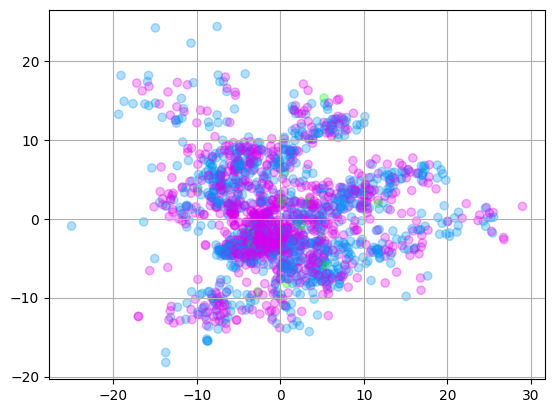

In [34]:
plt_embed = nlpsig.PlotEmbedding(x_data = x_data,
                                 y_data = df["label"].values)
plt_embed.plt_2d(
    embed_args = {
        "method": "pca",
        "dim": 2
    }
)

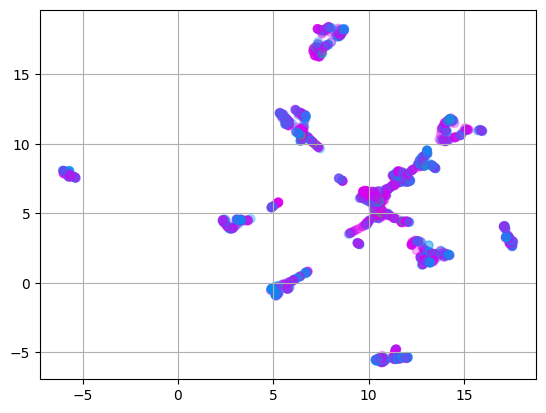

In [35]:
plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 3
    }
)

## Training a FFN for classification

First we set some parameters for this specific example:

In [36]:
input_dim = x_data.shape[1]
hidden_dim = 200 #200
output_dim = 3
dropout_rate = 0.35 #0.35 #higher dropout than 0.25 and specifically 0.35 is very promising
num_epochs = 100
learning_rate = 0.0003 #0.0003 #empirically optimal lr value: 0.0001
gamma = 2 #3 #empirically optimal gamma value: 3
BATCH_SIZE = 64
NUM_folds = 5
patience = 2
weight_decay_adam = 0.0001

### KFold (splitting by groups)

The `GroupFolds` class in `nlpsig` splits the data in folds which can be used later on for K-Fold validation. We can pass in the groups into the initialisation of the object as follows:

In [37]:
data_folds = nlpsig.GroupFolds(df = df,
                               x_data = x_data,
                               y_data = torch.tensor(df["label"]),
                               groups = df["timeline_id"],
                               n_splits = NUM_folds)

By default, the class uses the [`GroupKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) class from [scikit-learn](https://scikit-learn.org/stable/). This ensures that each group will appear exactly once in the test set across all folds, but it does not allow for shuffling the dataset.

If you'd like to shuffle the dataset, you can set `shuffle = True` (remember to set a seed number in `random_state` - but even if you don't, this defaults to `42`). In this case, the class uses [`GroupShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html). This *does not* ensure that each group will appear at least once in a test set. So in this choice, it is possible that some groups are never used to test in the K-Fold evalatuion.

In [38]:
data_folds_shuffled = nlpsig.GroupFolds(df = df,
                                        x_data = x_data,
                                        y_data = torch.tensor(df["label"]),
                                        groups = df["timeline_id"],
                                        n_splits = NUM_folds,
                                        shuffle = True,
                                        random_state = 2022)

The indicies for each fold are saved in `fold_indices` attribute

In [39]:
data_folds.fold_indices[0]

(array([   0,    1,    2, ..., 1997, 1998, 1999]),
 array([ 514,  515,  516,  517,  518,  519,  520,  521,  522,  523,  524,
         525,  526,  527,  528,  529,  530,  531,  532,  533,  534,  535,
         536,  537,  538,  539,  540,  541,  542,  543,  544,  545,  546,
         547,  548,  549,  550,  551,  552,  553,  554,  555,  556,  557,
         558,  559,  560,  561,  562,  563,  564,  565,  566,  567,  568,
         569,  570,  571,  572,  573,  574,  575,  576,  577,  578,  579,
         580,  581,  582,  583,  584,  585,  586,  587,  588,  589,  590,
         591,  592,  593,  594,  595,  596,  597,  598,  599,  600,  601,
         602,  603,  604,  605,  606,  607,  608,  609,  610,  611,  612,
         613,  614,  615,  616,  617,  618,  619,  620,  621,  622,  623,
         624,  625,  626,  627,  628,  629,  630,  631,  632,  633,  634,
         635,  636,  637,  638,  639,  640,  641,  642,  643,  644,  645,
         646,  647,  648,  649,  650,  651,  652,  653,  654,

We can obtain training dataset, validation dataset, test datasets via the `.get_splits()` method, which slices the data using the indicies stored in `fold_indices` for a given fold. For example, if we wanted training, validation, and test datasets for the first fold, we have:

In [40]:
data_folds.get_splits(0)

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00, -8.5027e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00, -8.5027e-01],
         [ 0.0000e+00, -6.9825e-01,  2.9663e+00,  ...,  7.4506e-09,
           0.0000e+00, -8.5027e-01],
         ...,
         [ 0.0000e+00, -9.3645e-01,  4.6519e-01,  ..., -2.1069e+00,
           8.0864e-01,  1.5003e+00],
         [ 0.0000e+00, -1.7582e-01,  2.9955e+00,  ..., -3.5911e+00,
           1.8453e+00,  1.5003e+00],
         [ 0.0000e+00, -2.4679e-01,  3.0701e+00,  ..., -3.8461e+00,
           1.9236e+00,  1.5003e+00]]),
 tensor([1, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
         2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 2, 2,
         2, 0, 0, 2, 0, 0, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2,
         2, 2, 2, 2, 2, 0, 2, 

By default, these will be in torch Tensors, but if we wanted them in as torch `DataLoader` objects, we set `as_DataLoader = True`:

In [41]:
data_folds.get_splits(fold_index = 0,
                      as_DataLoader = True)

(<torch.utils.data.dataloader.DataLoader at 0x2a1afb880>,
 <torch.utils.data.dataloader.DataLoader at 0x2a1cb2d00>)

### Fitting a PyTorch model

There are `validation_pytorch`, `training_pytorch` and `testing_pytorch` functions which we can use to train our model. We will do this with the first fold given above:

In [42]:
train, valid, test = data_folds.get_splits(fold_index = 0,
                                           as_DataLoader = True)

`training_pytorch` does all the training (and uses the validation set and `validation_pytorch` to do so):

In [43]:
# initial model definitions
model = FeedforwardNeuralNetModel(input_dim,
                                  hidden_dim,
                                  output_dim,
                                  dropout_rate)
criterion = FocalLoss(gamma = gamma)
# set the alpha value in FocalLoss by passing in the y_labels
# I just noticed that you do this only using the y_labels for the training set, I'll fix this later!
criterion.set_alpha_from_y(y = torch.tensor(df["label"]))
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             weight_decay = weight_decay_adam)

In [44]:
trained_model = nlpsig.training_pytorch(model = model,
                                        train_loader = train,
                                        valid_loader = valid,
                                        criterion = criterion,
                                        optimizer = optimizer,
                                        num_epochs=1000,
                                        seed = 2022,
                                        verbose = True)

Epoch: 1/1000 || Item: 0/1017 || Loss: 0.5923486948013306
Epoch: 1/1000 || Item: 1000/1017 || Loss: 0.3315490186214447
--------------------------------------------------
##### Epoch: 1/1000 || Loss: 0.12405608594417572
--------------------------------------------------
Epoch: 1 || Loss: 0.8818024955280943 || Accuracy: 0.5169660449028015 || F1-score: 0.2849451859378969.
Early stopping at epoch 37!


Lets see how well it performs on the test set:

In [45]:
predicted, labels = nlpsig.testing_pytorch(model = model,
                                           test_loader = test)

In [46]:
print("accuracy: " + str(((predicted == labels).sum() / labels.size(0)).item()))

accuracy: 0.5684647560119629


### KFold evaluation of a PyTorch model

We have created a function called `KFold_pytorch` which allows you to pass in a `GroupFolds` object (which stores the folds and data), a Pytorch model, loss function and optimizer in and will perform the K-Fold evaluation. This returns the accuracy and F1-scores of each fold as a dataframe.

We need to initialise the models first. It is vital that these are untrained, as we will do the K-Fold evaluation by first saving the PyTorch model and optimizer states. For each fold, these are re-loaded and then training and testing is performed for that particular fold.

In [47]:
# initial model definitions
model = FeedforwardNeuralNetModel(input_dim,
                                  hidden_dim,
                                  output_dim,
                                  dropout_rate)
criterion = FocalLoss(gamma = gamma)
# set the alpha value in FocalLoss by passing in the y_labels
# I just noticed that you do this only using the y_labels for the training set, I'll fix this later!
criterion.set_alpha_from_y(y = torch.tensor(df["label"]))
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             weight_decay = weight_decay_adam)

We simply pass this into `KFold_pytorch` function as follows:

In [48]:
kfold_eval = nlpsig.KFold_pytorch(data_folds,
                                  model = model,
                                  criterion = criterion,
                                  optimizer = optimizer,
                                  num_epochs = 1000,
                                  verbose_args = {
                                      "verbose": True,
                                      "verbose_epoch": 20,
                                      "verbose_item": 10000
                                  })


**************************************************
Fold: 1 / 5
**************************************************
Epoch: 1/1000 || Item: 0/1017 || Loss: 3.495075225830078
--------------------------------------------------
##### Epoch: 1/1000 || Loss: 1.3511180877685547
--------------------------------------------------
Epoch: 1 || Loss: 0.7687017648125778 || Accuracy: 0.4391217529773712 || F1-score: 0.2929825707349467.
Epoch: 21/1000 || Item: 0/1017 || Loss: 0.07917753607034683
--------------------------------------------------
##### Epoch: 21/1000 || Loss: 0.04310809075832367
--------------------------------------------------
Epoch: 21 || Loss: 3.890637304693614 || Accuracy: 0.5029940009117126 || F1-score: 0.3087457998263299.
Early stopping at epoch 23!

**************************************************
Fold: 2 / 5
**************************************************
Epoch: 1/1000 || Item: 0/1110 || Loss: 1.9791803359985352
--------------------------------------------------
##### Epoc

The accuracy and F1-scores are then saved as follows:

In [49]:
kfold_eval

,accuracy,f1_score
0,0.547718,0.347179
1,0.501458,0.280502
2,0.527697,0.231162
3,0.551020,0.248986
4,0.447853,0.291718
